## Diamond prices

In [88]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from module import *  # in-house module

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

## Load main dataset
df = sns.load_dataset('diamonds')
df = df[['price','carat','color','cut','clarity']]
errors = pd.DataFrame()  # used to store errors for plotting

## Project-wide toggles
intercept = True  # intercept for OLS models
scoring = 'neg_mean_absolute_error'  # scoring method for cross-validation

## Define function to yield actual errors from cross-validation process
def get_errors(data, model, exog, endog):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1996)
    errors = pd.DataFrame()

    # yield cv errors
    for tr, tt in kfold.split(data):
        xtr, ytr = data.iloc[tr][exog], data.iloc[tr][endog]
        xtt, ytt = data.iloc[tt][exog], data.iloc[tt][endog]
        model.fit(xtr, ytr)

        ypred = model.predict(xtt).reshape(-1,1)
        errors = errors.append(abs(ypred - ytt), ignore_index=True)

    return errors.replace([-np.inf, np.inf], np.nan)

Text(0.5, 1.0, 'Basic data exploration')

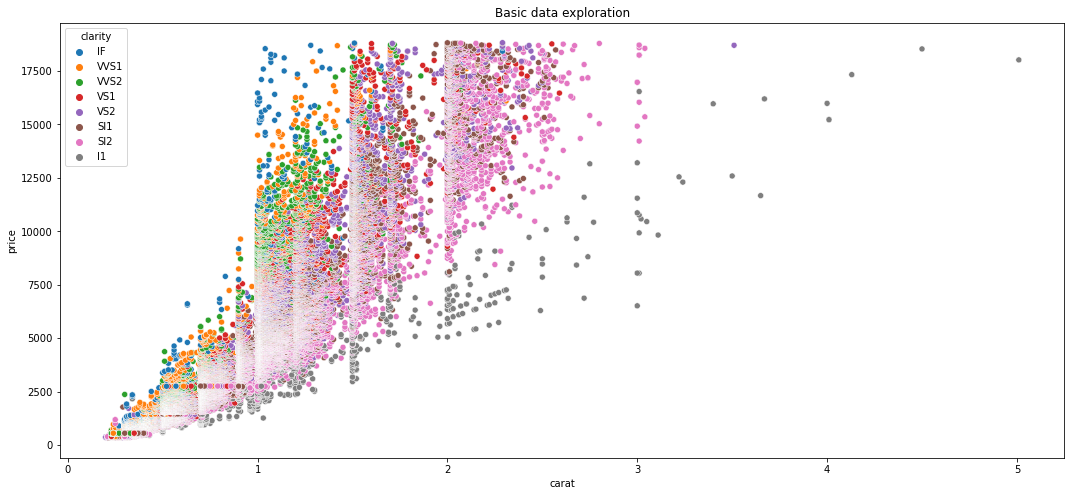

In [100]:
fig, ax = plt.subplots(1,1,figsize=(18,8))

sns.scatterplot(x='carat', y='price', hue='clarity', cmap='viridis', data=df).set_title('Basic data exploration')

Initial look at data suggests that diamond price may be quadratic in carat, and that it may also be explained by qualitative characteristics such as clarity. Data also appears to be truncated at prices of around $18,000.

## $price = \beta_{0} + \beta_{1}*carat + \epsilon$

In [90]:
## Basic regression

y = ['price']
X = ['carat']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept = intercept))
])

cross_val_score(estimator=pipe,
                X = df[X],
                y = df[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-1007.5660222146155

A trivial OLS regression explains diamond prices relatively well, with the average prediction missing by around $1,000 in either direction.

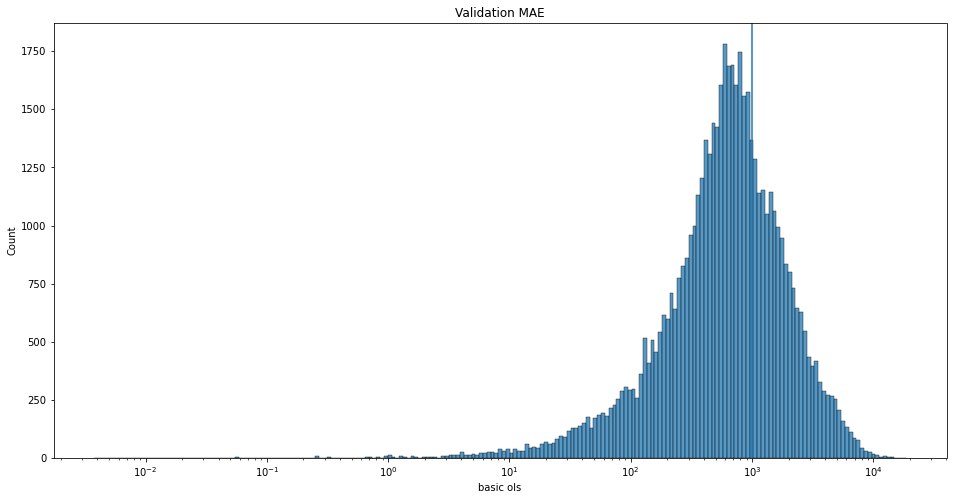

In [91]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['basic ols'] = get_errors(data=df, model=pipe, exog=X, endog=y)
sns.histplot(errors['basic ols'], log_scale=True, ax=ax).set_title('Validation MAE')
ax.axvline(x=errors['basic ols'].mean(), c='C0')

## $price = \beta_{0} + \beta_{1}*carat + \beta_{2}*carat^2 + \epsilon$

In [92]:
## Allow prices to be quadratic in carats: price ~ b0 + b1*carat * b2*carat^2 + e

df['carat^2'] = df.carat**2

y = ['price']
X = ['carat','carat^2']

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept = intercept))
])

cross_val_score(estimator = pipe,
                X = df[X],
                y = df[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-953.9766820568611

Allowing prics to be quadratic in prices provides a disappointingly small improvement in predictive capacity.

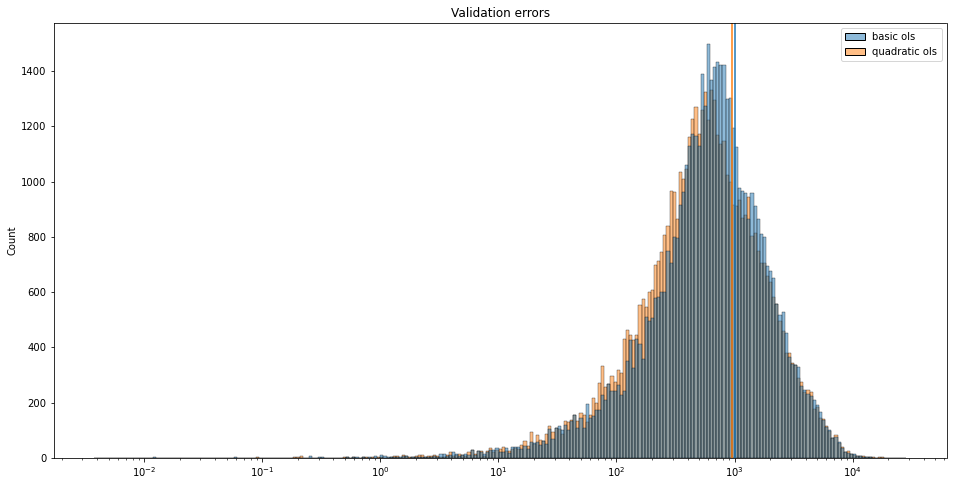

In [93]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['quadratic ols'] = get_errors(data=df, model=pipe, exog=X, endog=y)
sns.histplot(errors, log_scale=True, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')

## $price = \beta_{0} + \beta_{1}*carat + \beta_{2}*carat^2 + \beta_{3}*VVS1 + \beta{4}*VVS2 + ... + \epsilon$

In [94]:
## Regression with dummies for categories: price ~ b0 + b1*carat + b2*carat^2 + b3*VVS1 + ... + e

df_dummies = df.drop(['cut','color','clarity'], axis='columns')\
    .join(pd.get_dummies(df.cut, drop_first=True))\
    .join(pd.get_dummies(df.color, drop_first=True))\
    .join(pd.get_dummies(df.clarity, drop_first=True))

y = ['price']
X = [col for col in df_dummies.columns if col != y[0]]

pipe = Pipeline([
    ('ols', LinearRegression(fit_intercept=intercept))
])

cross_val_score(estimator = pipe,
                X = df_dummies[X],
                y = df_dummies[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-773.0550338559972

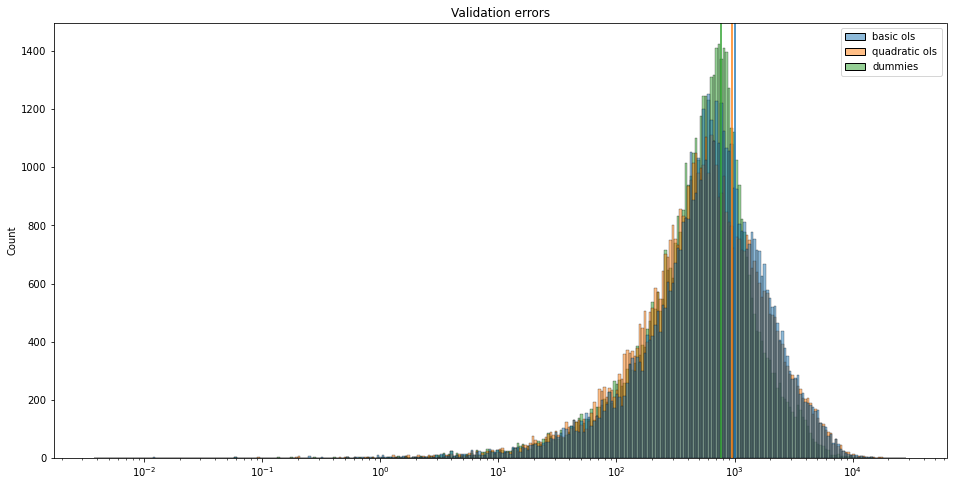

In [95]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

errors['dummies'] = get_errors(data=df_dummies, model=pipe, exog=X, endog=y)
sns.histplot(errors, log_scale=True, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')

One-hot encoding qualitative characteristics is feasible here since there aren't too many categories, and these dummy variables improve predictive capacity. Average prediction is now off by only 700 dollars. Decision-tree approaches may make better use of qualitative information, however.

## Random forest regression

In [98]:
## Random forest

df_rf = df.copy()
df_rf.cut = df_rf.cut.astype('category').cat.codes
df_rf.color = df_rf.color.astype('category').cat.codes
df_rf.clarity = df_rf.clarity.astype('category').cat.codes

df_rf_trim = df[df.price <= df.price.mean() + df.price.std()]

y = ['price']
X = [col for col in df_rf_trim.columns if col != y[0]]

pipe = Pipeline([
    ('fst', RandomForestRegressor(n_estimators=100, max_depth=100, random_state=1996))
])

cross_val_score(estimator = pipe,
                X = df_rf[X],
                y = df_rf[y],
                cv = KFold(n_splits=5, shuffle=True, random_state=1996),
                scoring = scoring).mean()

-296.0235274742099

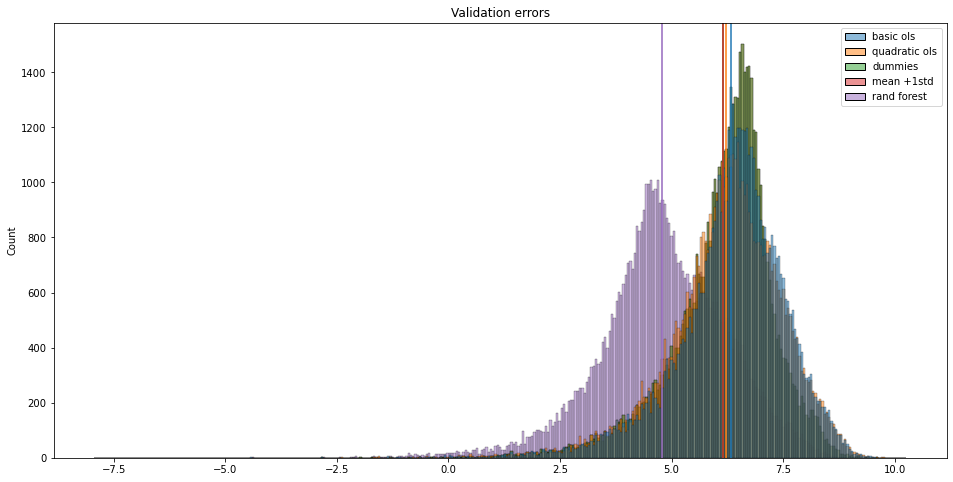

In [99]:
fig, ax = plt.subplots(1,1, figsize=(16,8))

## log transformations need to be applied outside of the plotting function in this case
## since errors of 0 become -inf which the histogram method rejects

errors['rand forest'] = get_errors(data=df_rf, model=pipe, exog=X, endog=y)

errors = errors.apply(np.log).replace(-np.inf, np.nan)  # manually apply log transform

sns.histplot(errors, log_scale=False, ax=ax).set_title('Validation errors')

for pos, col in enumerate(errors.columns):
    ax.axvline(x=errors[col].mean(), c=f'C{pos}')